Epoch [100/2000], d_loss: 0.0348, g_loss: 3.5634
Epoch [200/2000], d_loss: 0.0169, g_loss: 4.6697
Epoch [300/2000], d_loss: 0.0007, g_loss: 7.6366
Epoch [400/2000], d_loss: 0.0004, g_loss: 8.1160
Epoch [500/2000], d_loss: 0.0005, g_loss: 7.6854
Epoch [600/2000], d_loss: 0.0003, g_loss: 8.3403
Epoch [700/2000], d_loss: 0.0002, g_loss: 8.8410
Epoch [800/2000], d_loss: 0.0001, g_loss: 9.7419
Epoch [900/2000], d_loss: 0.0000, g_loss: 10.4569
Epoch [1000/2000], d_loss: 0.0000, g_loss: 11.6556
Epoch [1100/2000], d_loss: 0.0000, g_loss: 11.8498
Epoch [1200/2000], d_loss: 0.0000, g_loss: 12.5698
Epoch [1300/2000], d_loss: 0.0000, g_loss: 13.5957
Epoch [1400/2000], d_loss: 0.0000, g_loss: 14.7298
Epoch [1500/2000], d_loss: 0.0000, g_loss: 15.2563
Epoch [1600/2000], d_loss: 0.0000, g_loss: 15.6323
Epoch [1700/2000], d_loss: 0.0000, g_loss: 15.9375
Epoch [1800/2000], d_loss: 0.0000, g_loss: 15.1864
Epoch [1900/2000], d_loss: 0.0000, g_loss: 15.5624
Epoch [2000/2000], d_loss: 0.0000, g_loss: 15.67

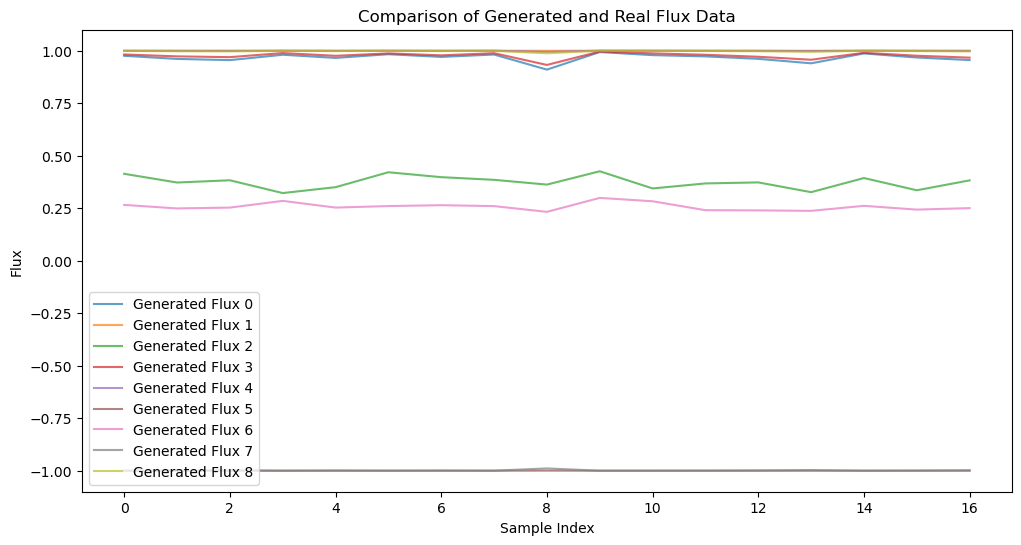

In [16]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define Generator
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_units=[128, 256, 512]):
        super(Generator, self).__init__()
        layers = []
        current_dim = input_dim
        
        for units in hidden_units:
            layers.append(nn.Linear(current_dim, units))
            layers.append(nn.ReLU())
            current_dim = units
        
        layers.append(nn.Linear(current_dim, output_dim))
        layers.append(nn.Tanh())  # Assuming output values are scaled to [-1, 1]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_units=[512, 256, 128]):
        super(Discriminator, self).__init__()
        layers = []
        current_dim = input_dim
        
        for units in hidden_units:
            layers.append(nn.Linear(current_dim, units))
            layers.append(nn.ReLU())
            current_dim = units
            
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())  # Output probability

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Train the GAN
def train_gan(data, num_epochs=1000, batch_size=17, learning_rate=0.0002, 
              generator_units=[128, 256, 512], discriminator_units=[512, 256, 128]):
    input_dim = data.shape[1] - 1  # Number of features (fluxes)

    generator = Generator(input_dim=10, output_dim=input_dim, hidden_units=generator_units)
    discriminator = Discriminator(input_dim=input_dim, hidden_units=discriminator_units)

    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for i in range(0, len(data), batch_size):
            # Use iloc for DataFrame indexing
            real_data = torch.tensor(data.iloc[i:i + batch_size, 1:].values, dtype=torch.float32)  # Exclude wavelength
            batch_size_current = real_data.size(0)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_labels = torch.ones(batch_size_current, 1)
            fake_labels = torch.zeros(batch_size_current, 1)

            outputs = discriminator(real_data)
            d_loss_real = criterion(outputs, real_labels)

            noise = torch.randn(batch_size_current, 10)  # Random noise input
            fake_data = generator(noise)
            outputs = discriminator(fake_data.detach())
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            outputs = discriminator(fake_data)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            optimizer_G.step()

        # Print losses
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')
    
    return generator

# Generate new fluxes and compare
def generate_and_compare(generator, original_data, num_samples=17):
    noise = torch.randn(num_samples, 10)
    generated_data = generator(noise).detach().numpy()

    # Extract real fluxes from original data for comparison
    real_fluxes = original_data.iloc[:, 1:].values  # Exclude wavelength

    # Plot the generated vs real data (for comparison)
    plt.figure(figsize=(12, 6))
    for i in range(real_fluxes.shape[1]):
        plt.plot(generated_data[:, i], label=f'Generated Flux {i}', alpha=0.7)
        # plt.plot(real_fluxes[:, i], label=f'Real Flux {i}', alpha=0.5)
    plt.xlabel('Sample Index')
    plt.ylabel('Flux')
    plt.legend()
    plt.title('Comparison of Generated and Real Flux Data')
    plt.show()

# Example dataset loading
# data = pd.read_csv('your_dataset.csv')  # Load your dataset here
data = pd.read_csv('../data/interpolated_spectra.csv')  # Load your dataset here
data = data.T
# Assuming data is shaped (17, 10)
# Call the training function with adjustable parameters
generator = train_gan(
    data,
    num_epochs=2000,  # Increase epochs for better training
    batch_size=17,
    learning_rate=0.0001,  # Try a different learning rate
    generator_units=[256, 512, 1024],  # Adjust hidden units for Generator
    discriminator_units=[1024, 512, 256]  # Adjust hidden units for Discriminator
)

# Generate and compare results
generate_and_compare(generator, data)


In [17]:
# Example dataset loading
data = pd.read_csv('../data/interpolated_spectra.csv')  # Load your dataset here
data = data.T

Epoch [100/1000], d_loss: 0.0006, g_loss: 0.9680
Epoch [200/1000], d_loss: 0.0003, g_loss: 0.9777
Epoch [300/1000], d_loss: 0.0002, g_loss: 0.9816
Epoch [400/1000], d_loss: 0.0001, g_loss: 0.9839
Epoch [500/1000], d_loss: 0.0001, g_loss: 0.9861
Epoch [600/1000], d_loss: 0.0001, g_loss: 0.9878
Epoch [700/1000], d_loss: 0.0001, g_loss: 0.9890
Epoch [800/1000], d_loss: 0.0001, g_loss: 0.9896
Epoch [900/1000], d_loss: 0.0001, g_loss: 0.9905


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [1000/1000], d_loss: 0.0000, g_loss: 0.9910
Shape of generated_data: (1, 17, 9)


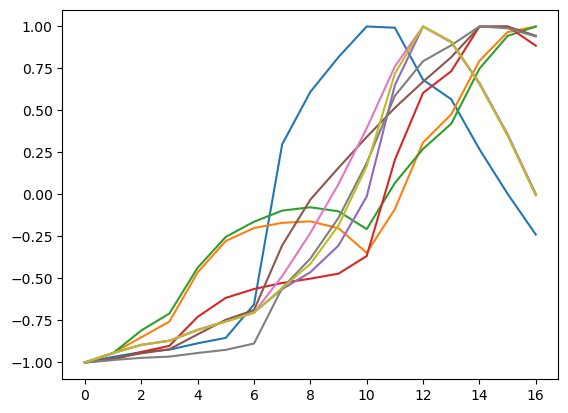

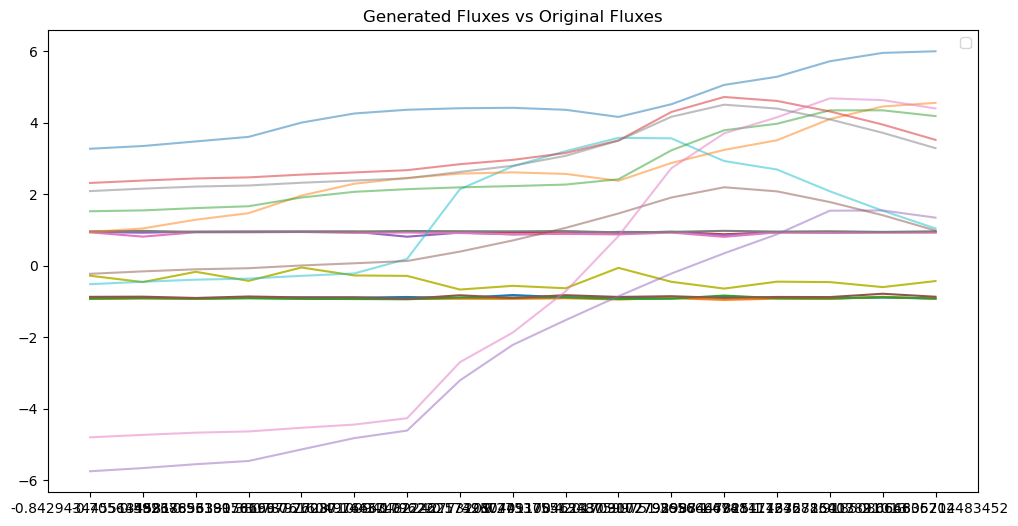

In [35]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Configuration class for hyperparameters
class Config:
    def __init__(self):
        self.num_epochs = 1000          # Increased number of epochs for training
        self.batch_size = 17             # Size of the batches used for training
        self.learning_rate = 0.0001      # Learning rate for the Adam optimizer
        self.generator_units = [64, 128, 256]  # Hidden units for the Generator LSTM
        self.discriminator_units = [128, 64, 32]  # Hidden units for the Discriminator LSTM
        # Hidden units for the Discriminator LSTM
        self.sequence_length = 16         # Length of sequences for LSTM
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, num_hidden_layers, hidden_units, seq_length):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_units, num_layers=2, batch_first=True, dropout=0.2)
        
        self.fc_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.fc_layers.append(nn.Linear(hidden_units, hidden_units))
            self.fc_layers.append(nn.ReLU())
            self.fc_layers.append(nn.LayerNorm(hidden_units))
        
        self.fc_layers.append(nn.Linear(hidden_units, output_dim))
        self.fc_layers.append(nn.Tanh())

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]  # Get the last output for the last time step
        
        # Handle case where lstm_out is 2D (single sample)
        if last_output.dim() == 2:
            last_output = last_output.unsqueeze(0)  # Add batch dimension

        for layer in self.fc_layers:
            last_output = layer(last_output)
        
        return last_output



class Discriminator(nn.Module):
    def __init__(self, input_dim, num_hidden_layers, hidden_units, seq_length):
        super(Discriminator, self).__init__()
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_units, num_layers=2, batch_first=True, dropout=0.2)

        # Fully connected layers
        self.fc_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.fc_layers.append(nn.Linear(hidden_units, hidden_units))  # Ensure the size matches
            self.fc_layers.append(nn.LeakyReLU(0.2))  # Using Leaky ReLU
            self.fc_layers.append(nn.LayerNorm(hidden_units))  # Layer Normalization
        
        # Final output layer
        self.fc_layers.append(nn.Linear(hidden_units, 1))
        self.fc_layers.append(nn.Sigmoid())  # Output probability

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]  # Get the last output for the last time step
        
        for layer in self.fc_layers:
            last_output = layer(last_output)
        
        return last_output


# Normalize the data
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    return scaler.fit_transform(data)

def train_gan(data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Normalize and reshape the data
    data = normalize_data(data.iloc[:, 1:])  # Normalize flux data
    input_dim = data.shape[1]  # Number of features (fluxes)
    plt.plot(data)
    # Prepare sequences for LSTM
    data_sequences = []
    for i in range(len(data) - config.sequence_length):
        data_sequences.append(data[i:i + config.sequence_length])
    data_sequences = np.array(data_sequences)

# Initialize parameters
    input_dim = 9  # Example input dimension based on your data
    output_dim = 9  # Example output dimension
    seq_length = config.sequence_length  # Use sequence length from config
    num_hidden_layers = 20  # User-defined number of hidden layers
    hidden_units = 128  # User-defined number of neurons

    # Create instances of the models
    generator = Generator(input_dim, output_dim, num_hidden_layers, hidden_units, seq_length).to(device)
    discriminator = Discriminator(input_dim, num_hidden_layers, hidden_units, seq_length).to(device)

    criterion = nn.MSELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=config.learning_rate)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=config.learning_rate)

    for epoch in range(config.num_epochs):
        for i in range(0, len(data_sequences), config.batch_size):
            real_data = torch.tensor(data_sequences[i:i + config.batch_size], dtype=torch.float32).to(config.device)
            batch_size_current = real_data.size(0)

            if batch_size_current == 0:
                continue

            real_labels = torch.ones(batch_size_current, 1).to(config.device)
            fake_labels = torch.zeros(batch_size_current, 1).to(config.device)

            # Train Discriminator
            optimizer_D.zero_grad()
            outputs = discriminator(real_data)

            # Ensure both outputs and real_labels are of the same shape
            d_loss_real = criterion(outputs.view(-1), real_labels.view(-1))  # Flatten both for comparison

            noise = torch.randn(batch_size_current, config.sequence_length, input_dim).to(config.device)
            fake_data = generator(noise)
            outputs = discriminator(fake_data.detach())

            # Ensure both outputs and fake_labels are of the same shape
            d_loss_fake = criterion(outputs.view(-1), fake_labels.view(-1))

            # Combine losses
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            # Train Generator
            optimizer_G.zero_grad()
            outputs = discriminator(fake_data)

            # Ensure both outputs and real_labels are of the same shape
            g_loss = criterion(outputs.view(-1), real_labels.view(-1))  # Ensure shapes match for generator loss
            g_loss.backward()
            optimizer_G.step()

        # Print losses
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{config.num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')
    
    return generator



# Generate new fluxes and compare
def generate_and_compare(generator, original_data, config, num_samples=17):
    noise = torch.randn(num_samples, config.sequence_length, 9).to(config.device)
    generated_data = generator(noise).detach().cpu().numpy()
    
    # Debugging: Print shape of generated data
    print("Shape of generated_data:", generated_data.shape)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    for i in range(min(num_samples, generated_data.shape[0])):  # Use the smaller of num_samples or generated_data.shape[0]
        plt.plot(generated_data[i])
    plt.plot(original_data.iloc[:, 1:], alpha=0.5)
    plt.legend()
    plt.title('Generated Fluxes vs Original Fluxes')
    plt.show()

# Load data
data = pd.read_csv('../data/interpolated_spectra.csv')  # Load your dataset here
data = data.T
# Initialize config
config = Config()

# Call the training function with the config
generator = train_gan(data)

# Generate and compare results
generate_and_compare(generator, data, config)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Shape of generated_data: (1, 17, 9)


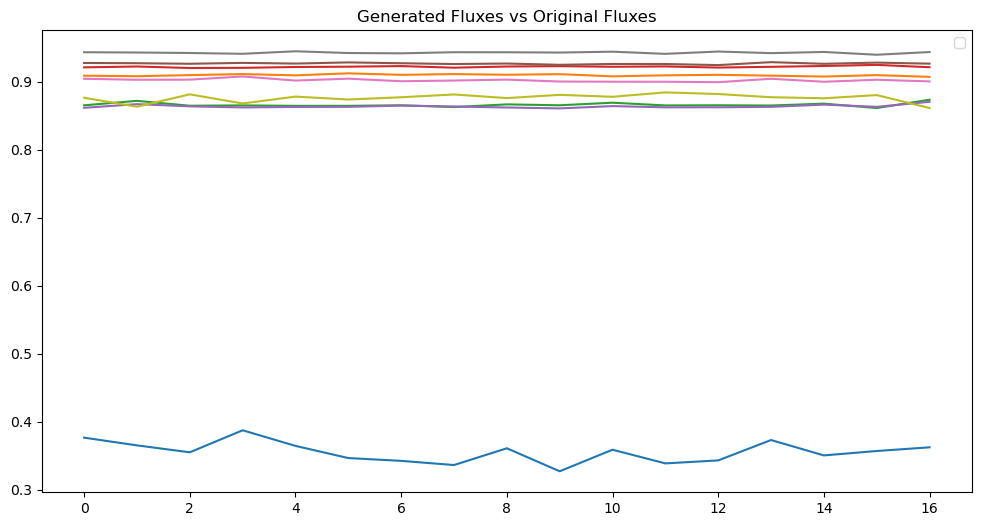

In [32]:
# Generate new fluxes and compare
def generate_and_compare(generator, original_data, config, num_samples=17):
    noise = torch.randn(num_samples, config.sequence_length, 9).to(config.device)
    generated_data = generator(noise).detach().cpu().numpy()
    
    # Debugging: Print shape of generated data
    print("Shape of generated_data:", generated_data.shape)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    for i in range(min(num_samples, generated_data.shape[0])):  # Use the smaller of num_samples or generated_data.shape[0]
        plt.plot(generated_data[i])
    # plt.plot(original_data.iloc[:, 1:], alpha=0.5)
    plt.legend()
    plt.title('Generated Fluxes vs Original Fluxes')
    plt.show()
generate_and_compare(generator, data, config)


In [1]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim),  # output_dim = 17 * 9 for fluxes
        )
    
    def forward(self, z):
        generated_data = self.model(z)
        return generated_data.view(-1, 17, 9)  # Reshape for (17 wavelengths, 9 galaxies)


NameError: name 'nn' is not defined